In [76]:
import csv
import pandas as pd
import nltk
import time
import numpy as np
import string, re

from tensorflow import keras
from tensorflow.keras import layers

nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\prane\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\prane\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
combined_genre_data = pd.read_csv("combined_genre_data.csv")
combined_genre_data.head()

,Unnamed: 0,SName,Artist,Lyric,Genres
0,0,Country Boy,Muddy Waters,Don't say I don't love you\nBecause I stays ou...,Blues
1,1,Don't Wait 'til Tomorrow,Gary Clark Jr.,I'm so tired of fighting\nI'm so tired of bein...,Blues
2,2,Frankie,Mississippi John Hurt,"(spoken introduction:\n""Frankie and Albert"", t...",Blues
3,3,Fear Of Falling,The Allman Brothers Band,"by G. Allman, J. Townsend & T. Heding\nThere w...",Blues
4,4,I've Always Been Lonely,BB King,I don't have to know your name\nUnless you rea...,Blues


In [3]:
lyrics_list = list(combined_genre_data.Lyric)
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
lemmatizer = WordNetLemmatizer()
# stemmer = SnowballStemmer("english")
english = list(set(nltk.corpus.words.words()))

def clean_docs_lemma(lyrics_list):
    cleaned = []
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

In [4]:
lemmed_lyrics = clean_docs_lemma(lyrics_list)
len(lemmed_lyrics)

6000

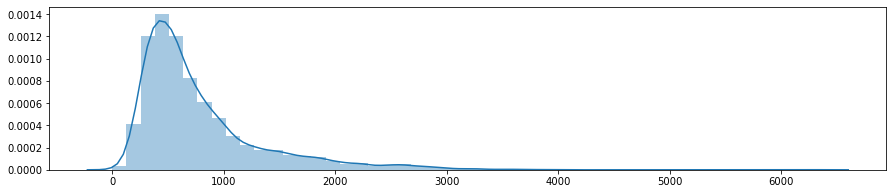

In [10]:
lyrics_lengths = [len(lyrics) for lyrics in lemmed_lyrics]
sns.distplot(lyrics_lengths)
plt.gcf().set_size_inches(15, 3)

# Neural Net

In [56]:
X = lemmed_lyrics
y = combined_genre_data.Genres

In [57]:
MAX_NB_WORDS = 25000
MAX_SEQUENCE_LENGTH = 800
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(lemmed_lyrics)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 28872 unique tokens.


In [58]:
X = tokenizer.texts_to_sequences(lemmed_lyrics)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (6000, 800)


In [59]:
y = pd.get_dummies(combined_genre_data.Genres).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (6000, 6)


In [81]:
le = LabelEncoder()
le.fit(combined_genre_data.Genres.values)

LabelEncoder()

In [82]:
le.classes_

array(['Blues', 'Country', 'Hip Hop', 'Jazz', 'Pop', 'Rock'], dtype=object)

In [75]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [73]:
combined_genre_data.Genres

0       Blues
1       Blues
2       Blues
3       Blues
4       Blues
        ...  
5995     Rock
5996     Rock
5997     Rock
5998     Rock
5999     Rock
Name: Genres, Length: 6000, dtype: object

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4500, 800)
(1500, 800)
(4500, 6)
(1500, 6)


In [64]:
model = keras.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 100

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)


Epoch 1/5
41/41 [==============================] - 1085s 26s/step - loss: 1.7838 - accuracy: 0.1970 - val_loss: 1.5410 - val_accuracy: 0.3578
Epoch 2/5
41/41 [==============================] - 625s 15s/step - loss: 1.5492 - accuracy: 0.3859 - val_loss: 1.4635 - val_accuracy: 0.3778
Epoch 3/5
41/41 [==============================] - 523s 13s/step - loss: 1.3569 - accuracy: 0.4422 - val_loss: 1.3347 - val_accuracy: 0.4356
Epoch 4/5
41/41 [==============================] - 543s 13s/step - loss: 1.1388 - accuracy: 0.5384 - val_loss: 1.3479 - val_accuracy: 0.4644
Epoch 5/5
41/41 [==============================] - 539s 13s/step - loss: 0.9421 - accuracy: 0.6651 - val_loss: 1.3066 - val_accuracy: 0.4978


In [65]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

47/47 [==============================] - 10s 210ms/step - loss: 1.3471 - accuracy: 0.4860
Test set
  Loss: 1.347
  Accuracy: 0.486


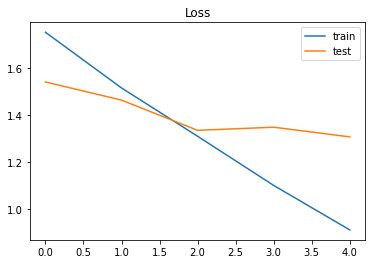

In [66]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

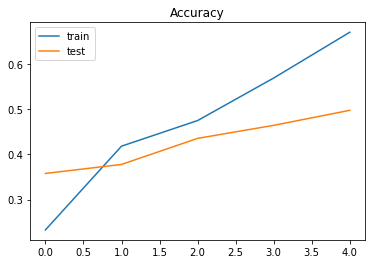

In [69]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [115]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [116]:
y_pred_classes_train = y_pred_train.argmax(axis=-1)
classified_train = le.inverse_transform(y_pred_classes_train)

y_train_classes = y_train.argmax(axis=-1)
gold_train = le.inverse_transform(y_train_classes)

In [117]:
y_pred_classes_test = y_pred_test.argmax(axis=-1)
classified_test = le.inverse_transform(y_pred_classes_test)

y_test_classes = y_test.argmax(axis=-1)
gold_test = le.inverse_transform(y_test_classes)

In [127]:
gold_train

array(['Hip Hop', 'Blues', 'Jazz', ..., 'Pop', 'Hip Hop', 'Rock'],
      dtype=object)

# Metrics

In [123]:
def score_report(classes, classified_train, gold_train, classified_test, gold_test):
    print("----------- Training Set Report -----------")
#     print("Accuracy", accuracy_score(y_train, y_train_pred))
    print("Precision", precision_multi(gold_train, classified_train))
    print("Recall", recall_multi(gold_train, classified_train))
    print("F1", f1_multi(gold_train, classified_train))
    cm = confusion_matrix(gold_train, classified_train, labels=classes)
    print("Confusion matrix", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()
    print("----------- Testing Set Report -----------")
#     print("Accuracy", accuracy_score(y_test, y_test_pred))
    print("Precision", precision_multi(gold_test, classified_test))
    print("Recall", recall_multi(gold_test, classified_test))
    print("F1", f1_multi(gold_test, classified_test))
    cm = confusion_matrix(gold_test, classified_test, labels=classes)
    print("Confusion matrix", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

In [124]:
from collections import Counter
from statistics import mean
def precision_multi_dict(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    classes = set(gold_labels)
    class_precisions = Counter()
    for _class in classes:
        den = 0
        num = 0
        for i in range(len(classified_labels)):
            if classified_labels[i] == _class:
                den += 1
                if gold_labels[i] == _class:
                    num += 1
        if den == 0:
            class_precisions[_class] = 0.0
        else:
            class_precisions[_class] = float(num / den)
    return class_precisions


def precision_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    precision_dict = precision_multiclass_dict(gold_labels, classified_labels)
    return float(mean(precision_dict.values()))

def recall_multi_dict(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    classes = set(gold_labels)
    class_recalls = Counter()
    for _class in classes:
        den = 0
        num = 0
        for i in range(len(gold_labels)):
            if gold_labels[i] == _class:
                den += 1
                if classified_labels[i] == _class:
                    num += 1
        if den == 0:
            class_precisions[_class] = 0.0
        else:
            class_recalls[_class] = float(num / den)
    return class_recalls



def recall_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    recall_dict = recall_multi_dict(gold_labels, classified_labels)
    return float(mean(recall_dict.values()))


def f1_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    precision_dict = precision_multiclass_dict(gold_labels, classified_labels)
    recall_dict = recall_multi_dict(gold_labels, classified_labels)

    classes = precision_dict.keys()

    f1_scores = []
    for _class in classes:
        class_precision = precision_dict[_class]
        class_recall = recall_dict[_class]
        if class_precision + class_recall == 0:
            f1_scores.append(0.0)
        else:
            f1_scores.append(float((2 * class_precision * class_recall) / (class_precision + class_recall)))

    return mean(f1_scores)


In [101]:
precision_multi_dict(gold_labels, classified_labels)

Counter({'Jazz': 0.5056497175141242,
         'Rock': 0.2883116883116883,
         'Hip Hop': 0.8325991189427313,
         'Blues': 0.532871972318339,
         'Country': 0.3464566929133858,
         'Pop': 0.4406779661016949})

In [102]:
precision_multi(gold_labels, classified_labels)

0.49109452601699394

In [103]:
recall_multi_dict(gold_labels, classified_labels)

Counter({'Jazz': 0.7276422764227642,
         'Rock': 0.4475806451612903,
         'Hip Hop': 0.756,
         'Blues': 0.6062992125984252,
         'Country': 0.16988416988416988,
         'Pop': 0.2139917695473251})

In [104]:
recall_multi(gold_labels, classified_labels)

0.48689967893566244

In [105]:
f1_multi(gold_labels, classified_labels)

0.4705195779090784

In [113]:
roc_auc_score(y_test, model.predict(X_test), multi_class='ovo')

0.8090267954166066

In [111]:
y_pred_classes

array([5, 3, 5, ..., 0, 0, 2], dtype=int64)

In [120]:
le.classes_

array(['Blues', 'Country', 'Hip Hop', 'Jazz', 'Pop', 'Rock'], dtype=object)

----------- Training Set Report -----------
Precision 0.7140799211990748
Recall 0.752984180732876
F1 0.7009765200750965
Confusion matrix [[659  21  15  16  35  48]
 [  5 259   2  16  22  43]
 [  1   0 681   0  78   3]
 [ 48 172   2 701  15  61]
 [  1  10  28   1 329  11]
 [ 32 279  22  20 278 586]]


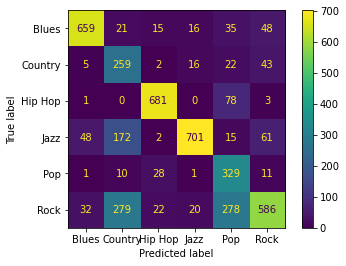

----------- Testing Set Report -----------
Precision 0.48689967893566244
Recall 0.49109452601699394
F1 0.4705195779090784
Confusion matrix [[154  28  12  36  24  35]
 [ 11  44   4  15  24  29]
 [  0   2 189   1  29   6]
 [ 45  67   1 179  13  49]
 [  6  14  25   3  52  18]
 [ 38 104  19  12 101 111]]


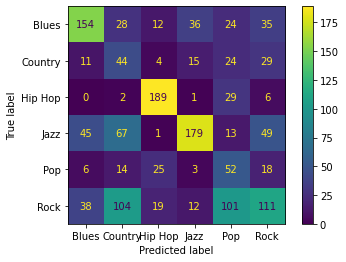

In [125]:
score_report(le.classes_, gold_train, classified_train, gold_test, classified_test)

In [126]:
accuracy_score(gold_test, classified_test)

0.486